In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
path = '/Users/Hanuman zalte/OneDrive/Desktop/world bank economic indicatos.csv'
data = pd.read_csv(path)

In [3]:
data_info = data.info()
data_head = data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7918 entries, 0 to 7917
Columns: 166 entries, Country to 2015 [2015]
dtypes: object(166)
memory usage: 10.0+ MB


In [4]:
data

,Country,Country Code,Series,Series Code,2024Q2 [2024Q2],2024Q1 [2024Q1],2024M06 [2024M06],2024M05 [2024M05],2024M04 [2024M04],2024M03 [2024M03],...,2018 [2018],2017Q4 [2017Q4],2017Q3 [2017Q3],2017Q2 [2017Q2],2017Q1 [2017Q1],2017M12 [2017M12],2017M11 [2017M11],2017M10 [2017M10],2015M01 [2015M01],2015 [2015]
0,Angola,AGO,"Core CPI,not seas.adj,,,",CORENS,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
1,Angola,AGO,"Core CPI,seas.adj,,,",CORESA,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
2,Angola,AGO,"CPI Price, % y-o-y, median weighted, seas. adj.,",CPTOTSAXMZGY,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
3,Angola,AGO,"CPI Price, % y-o-y, not seas. adj.,,",CPTOTSAXNZGY,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,7.582668138,..
4,Angola,AGO,"CPI Price, seas. adj.,,,",CPTOTSAXN,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,162.7491326,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7913,IPTOTNSKD,An economic indicator that measures changes in...,World Bank staff calculations based on Datastr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7914,NEER,A measure of the value of a currency against a...,World Bank staff calculations based on Datastr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7915,REER,Real effective exchange rate is the nominal ef...,World Bank staff calculations based on Datastr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7916,DSTKMKTXN,Local equity market index valued in local curr...,World Bank staff calculations based on Datastr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.replace('..', pd.NA, inplace=True)

In [6]:
missing_data = data.isna().sum()
print(missing_data)


Country                 3
Country Code            5
Series                  5
Series Code            34
2024Q2 [2024Q2]      7884
                     ... 
2017M12 [2017M12]    4580
2017M11 [2017M11]    4569
2017M10 [2017M10]    4562
2015M01 [2015M01]    3774
2015 [2015]          4147
Length: 166, dtype: int64


In [7]:
gdp_series_code = 'GDP,current US$,millions,seas. adj.,'
cpi_series_code = 'CPI Price, seas. adj.,,,'
exchange_rate   = 'Exchange rate, old LCU per USD extended forward, period average,,'

# Filter the dataset to include only the relevant indicators
key_indicators = data[data['Series'].isin([gdp_series_code, cpi_series_code, exchange_rate])]


In [8]:
# List columns related to time periods (e.g., years, quarters)
time_period_columns = [col for col in data.columns if any(year in col for year in ['2024Q2 [2024Q2]', '2024Q1 [2024Q1]',  '2023Q4 [2023Q4]', '2023Q3 [2023Q3]','2023Q2 [2023Q2]','2023Q1 [2023Q1]','2022Q4 [2022Q4]','2022Q3 [2022Q3]','2022Q2 [2022Q2]','2022Q1 [2022Q1]','2021Q4 [2021Q4]','2021Q3 [2021Q3]','2021Q2 [2021Q2]','2021Q1 [2021Q1]','2020Q4 [2020Q4]','2020Q3 [2020Q3]','2020Q2 [2020Q2]','2020Q1 [2020Q1]','2019Q4 [2019Q4]','2019Q3 [2019Q3]','2019Q2 [2019Q2]','2019Q1 [2019Q1]',
                                                                                  '2018Q4 [2018Q4]','2018Q3 [2018Q3]','2018Q2 [2018Q2]','2018Q1 [2018Q1]','2017Q4 [2017Q4]','2017Q3 [2017Q3]','2017Q2 [2017Q2]','2017Q1 [2017Q1]','2016Q4 [2016Q4]','2016Q3 [2016Q3]','2016Q2 [2016Q2]','2016Q1 [2016Q1]','2015Q4 [2015Q4]','2015Q3 [2015Q3]','2015Q2 [2015Q2]','2015Q1 [2015Q1]'])]

print("Time Period Columns:", time_period_columns)


Time Period Columns: ['2024Q2 [2024Q2]', '2024Q1 [2024Q1]', '2023Q4 [2023Q4]', '2023Q3 [2023Q3]', '2023Q2 [2023Q2]', '2023Q1 [2023Q1]', '2022Q4 [2022Q4]', '2022Q3 [2022Q3]', '2022Q2 [2022Q2]', '2022Q1 [2022Q1]', '2021Q4 [2021Q4]', '2021Q3 [2021Q3]', '2021Q2 [2021Q2]', '2021Q1 [2021Q1]', '2015Q2 [2015Q2]', '2015Q1 [2015Q1]', '2016Q3 [2016Q3]', '2016Q2 [2016Q2]', '2016Q1 [2016Q1]', '2015Q4 [2015Q4]', '2015Q3 [2015Q3]', '2016Q4 [2016Q4]', '2020Q3 [2020Q3]', '2020Q4 [2020Q4]', '2020Q2 [2020Q2]', '2020Q1 [2020Q1]', '2019Q4 [2019Q4]', '2019Q3 [2019Q3]', '2019Q1 [2019Q1]', '2019Q2 [2019Q2]', '2018Q4 [2018Q4]', '2018Q3 [2018Q3]', '2018Q2 [2018Q2]', '2018Q1 [2018Q1]', '2017Q4 [2017Q4]', '2017Q3 [2017Q3]', '2017Q2 [2017Q2]', '2017Q1 [2017Q1]']


In [9]:
long_format = key_indicators.melt(
    id_vars=['Country', 'Country Code', 'Series', 'Series Code'],
    value_vars=time_period_columns,
    var_name='Time Period',
    value_name='Value'
)


long_format['Time Period'] = pd.to_datetime(long_format['Time Period'].str.extract(r'(\d{4})')[0])


print(long_format.head())

              Country Country Code  \
0              Angola          AGO   
1              Angola          AGO   
2              Angola          AGO   
3  Advanced Economies          AME   
4  Advanced Economies          AME   

                                              Series    Series Code  \
0                           CPI Price, seas. adj.,,,      CPTOTSAXN   
1  Exchange rate, old LCU per USD extended forwar...      DPANUSSPF   
2               GDP,current US$,millions,seas. adj.,  NYGDPMKTPSACD   
3                           CPI Price, seas. adj.,,,      CPTOTSAXN   
4  Exchange rate, old LCU per USD extended forwar...      DPANUSSPF   

  Time Period Value  
0  2024-01-01  <NA>  
1  2024-01-01  <NA>  
2  2024-01-01  <NA>  
3  2024-01-01  <NA>  
4  2024-01-01  <NA>  


In [10]:
long_format.fillna(method='ffill', inplace=True)

C:\Users\Hanuman zalte\AppData\Local\Temp\ipykernel_11056\599904049.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  long_format.fillna(method='ffill', inplace=True)


In [11]:
print(long_format.head())

              Country Country Code  \
0              Angola          AGO   
1              Angola          AGO   
2              Angola          AGO   
3  Advanced Economies          AME   
4  Advanced Economies          AME   

                                              Series    Series Code  \
0                           CPI Price, seas. adj.,,,      CPTOTSAXN   
1  Exchange rate, old LCU per USD extended forwar...      DPANUSSPF   
2               GDP,current US$,millions,seas. adj.,  NYGDPMKTPSACD   
3                           CPI Price, seas. adj.,,,      CPTOTSAXN   
4  Exchange rate, old LCU per USD extended forwar...      DPANUSSPF   

  Time Period Value  
0  2024-01-01  <NA>  
1  2024-01-01  <NA>  
2  2024-01-01  <NA>  
3  2024-01-01  <NA>  
4  2024-01-01  <NA>  


In [12]:
#Time series analysis (GDP Forecasting)

country = 'India'
indicator = 'GDP,current US$,millions,seas. adj.,'

gdp_data = long_format[(long_format['Country'] == country) & (long_format['Series'] == indicator)]


gdp_data = gdp_data.sort_values(by='Time Period')


gdp_data.set_index('Time Period', inplace=True)


gdp_data['Value'] = pd.to_numeric(gdp_data['Value'], errors='coerce')


gdp_data.dropna(inplace=True)


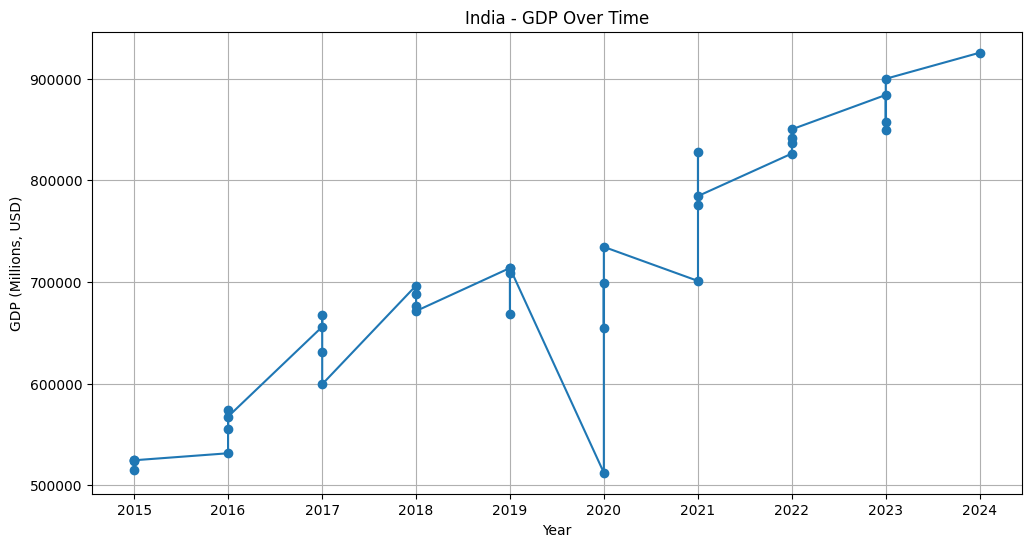

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(gdp_data.index, gdp_data['Value'], marker='o', linestyle='-')
plt.title(f'{country} - GDP Over Time')
plt.xlabel('Year')
plt.ylabel('GDP (Millions, USD)')
plt.grid(True)
plt.show()

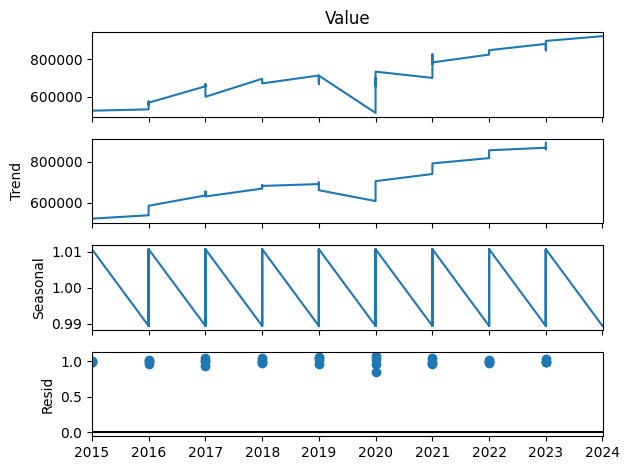

In [14]:
decomposition = seasonal_decompose(gdp_data['Value'], model='multiplicative', period=2)
decomposition.plot()
plt.show()


C:\Users\Hanuman zalte\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hanuman zalte\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hanuman zalte\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hanuman zalte\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWa

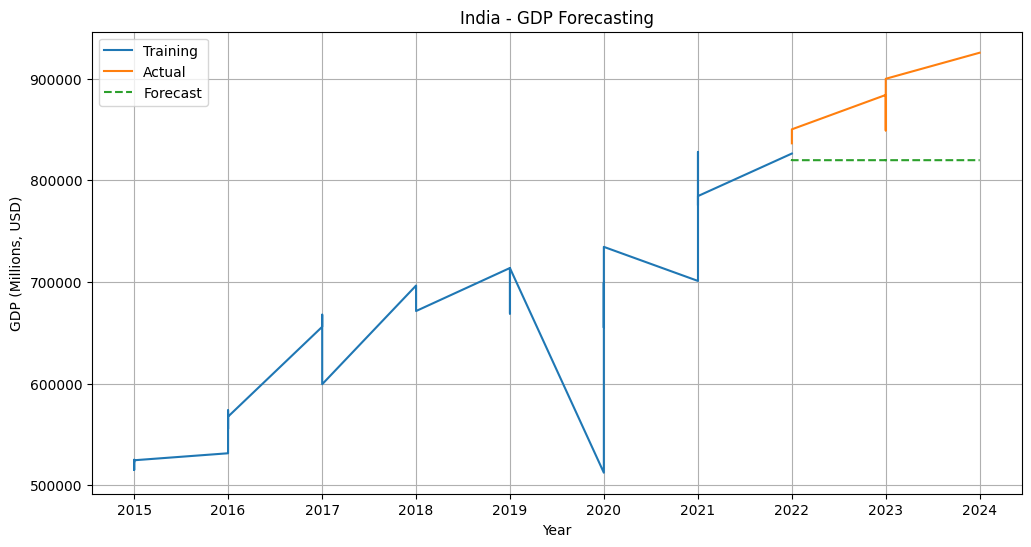

RMSE: 56666.37280516892


In [15]:
#  ARIMA Model for Forecasting
train_size = int(len(gdp_data) * 0.8)
train, test = gdp_data[:train_size], gdp_data[train_size:]

# Fit the ARIMA model 
model = ARIMA(train['Value'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast the future values
forecast = model_fit.forecast(steps=len(test))

# Plot the forecasted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Value'], label='Training')
plt.plot(test.index, test['Value'], label='Actual')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title(f'{country} - GDP Forecasting')
plt.xlabel('Year')
plt.ylabel('GDP (Millions, USD)')
plt.legend()
plt.grid(True)
plt.show()

#Calculate the RMSE
rmse = np.sqrt(mean_squared_error(test['Value'], forecast))
print(f'RMSE: {rmse}')


In [16]:
#Exchange rate forecasting

country = 'India'
indicator = 'Exchange rate, old LCU per USD extended forward, period average,,'

exchange_rate = long_format[(long_format['Country'] == country) & (long_format['Series'] == indicator)]


exchange_rate = exchange_rate.sort_values(by='Time Period')


exchange_rate.set_index('Time Period', inplace=True)


exchange_rate['Value'] = pd.to_numeric(exchange_rate['Value'], errors='coerce')


exchange_rate.dropna(inplace=True)

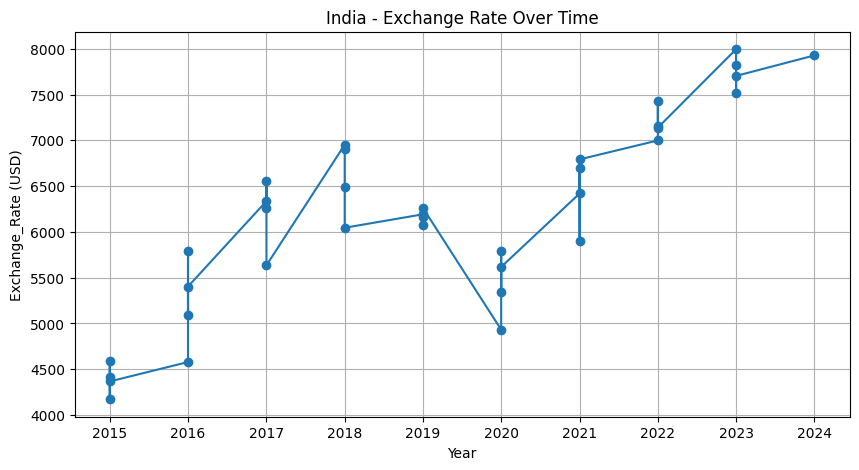

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(exchange_rate.index, exchange_rate['Value'], marker='o', linestyle='-')
plt.title(f'{country} - Exchange Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Exchange_Rate (USD)')

plt.grid(True)
plt.show()

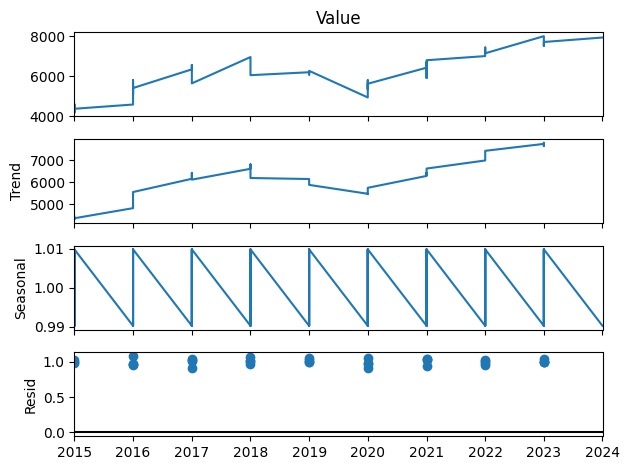

In [18]:
decomposition = seasonal_decompose(exchange_rate['Value'], model='multiplicative', period=2)
decomposition.plot()
plt.show()


C:\Users\Hanuman zalte\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hanuman zalte\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hanuman zalte\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hanuman zalte\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWa

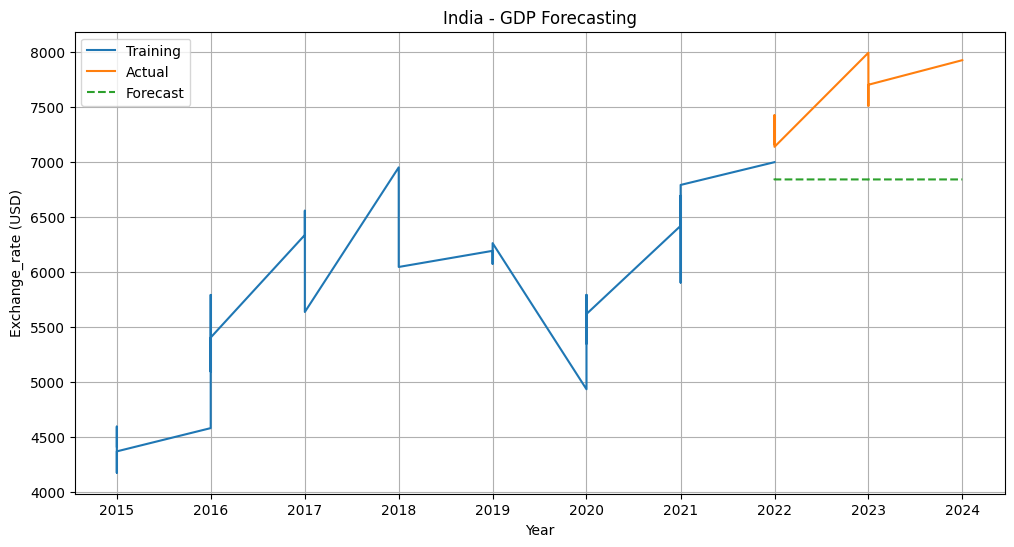

RMSE: 805.9145319693163


In [19]:
#  ARIMA Model for Forecasting
train_size = int(len(exchange_rate) * 0.8)
train, test = exchange_rate[:train_size], exchange_rate[train_size:]

# Fit the ARIMA model 
model = ARIMA(train['Value'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast the future values
forecast = model_fit.forecast(steps=len(test))

# Plot the forecasted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Value'], label='Training')
plt.plot(test.index, test['Value'], label='Actual')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title(f'{country} - GDP Forecasting')
plt.xlabel('Year')
plt.ylabel('Exchange_rate (USD)')
plt.legend()
plt.grid(True)
plt.show()

#Calculate the RMSE
rmse = np.sqrt(mean_squared_error(test['Value'], forecast))
print(f'RMSE: {rmse}')

In [20]:
#CPI forecasting

country = 'India'
indicator = 'CPI Price, seas. adj.,,,'

CPI = long_format[(long_format['Country'] == country) & (long_format['Series'] == indicator)]


CPI = CPI.sort_values(by='Time Period')


CPI.set_index('Time Period', inplace=True)


CPI['Value'] = pd.to_numeric(CPI['Value'], errors='coerce')


CPI.dropna(inplace=True)

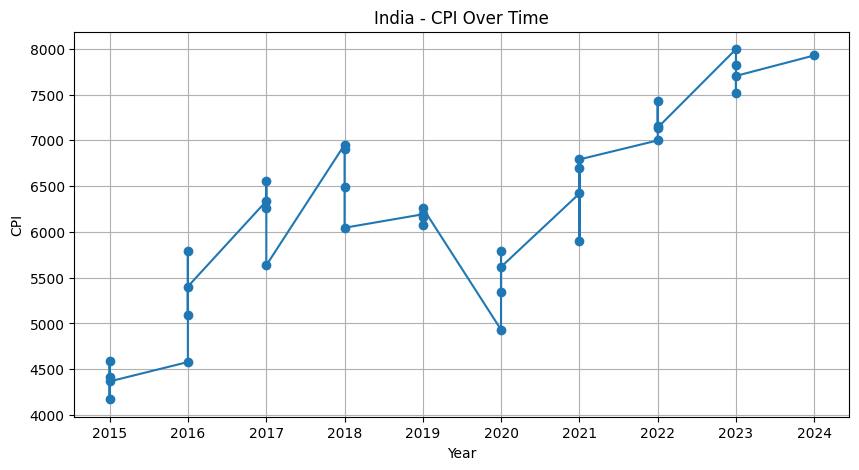

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(CPI.index, CPI['Value'], marker='o', linestyle='-')
plt.title(f'{country} - CPI Over Time')
plt.xlabel('Year')
plt.ylabel('CPI')

plt.grid(True)
plt.show()

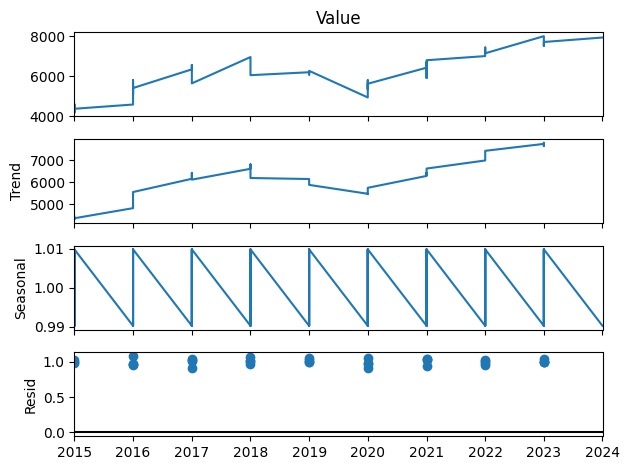

In [22]:
decomposition = seasonal_decompose(CPI['Value'], model='multiplicative', period=2)
decomposition.plot()
plt.show()


C:\Users\Hanuman zalte\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hanuman zalte\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hanuman zalte\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hanuman zalte\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWa

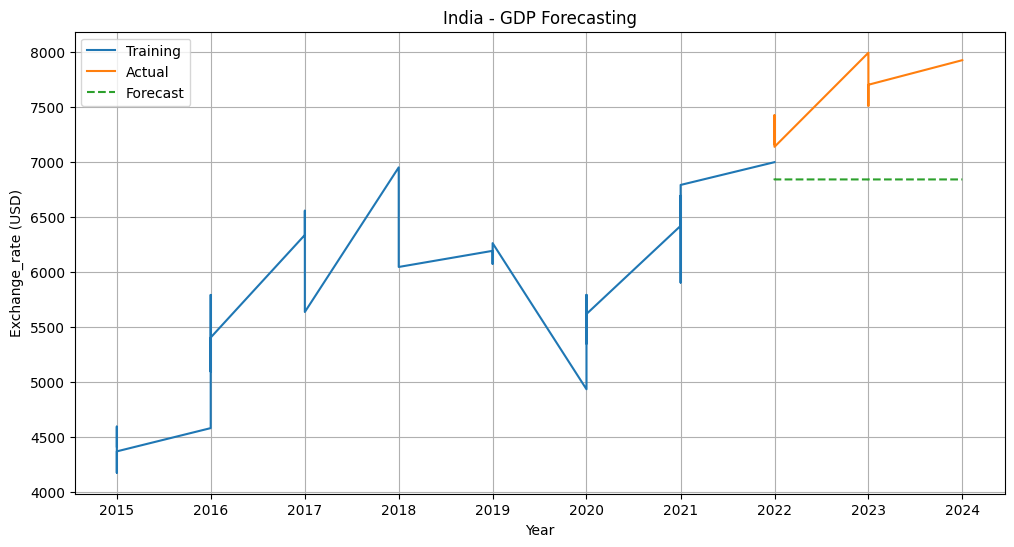

RMSE: 805.9145319693163


In [23]:
#  ARIMA Model for Forecasting
train_size = int(len(exchange_rate) * 0.8)
train, test = CPI[:train_size], CPI[train_size:]

# Fit the ARIMA model 
model = ARIMA(train['Value'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast the future values
forecast = model_fit.forecast(steps=len(test))

# Plot the forecasted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Value'], label='Training')
plt.plot(test.index, test['Value'], label='Actual')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title(f'{country} - GDP Forecasting')
plt.xlabel('Year')
plt.ylabel('Exchange_rate (USD)')
plt.legend()
plt.grid(True)
plt.show()

#Calculate the RMSE
rmse = np.sqrt(mean_squared_error(test['Value'], forecast))
print(f'RMSE: {rmse}')

C:\Users\Hanuman zalte\AppData\Local\Temp\ipykernel_11056\3320612872.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_indicators.replace('..', pd.NA, inplace=True)
C:\Users\Hanuman zalte\AppData\Local\Temp\ipykernel_11056\3320612872.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_indicators[columns_2020_onwards] = filtered_indicators[columns_2020_onwards].apply(pd.to_numeric, errors='coerce')


IndexError: single positional indexer is out-of-bounds

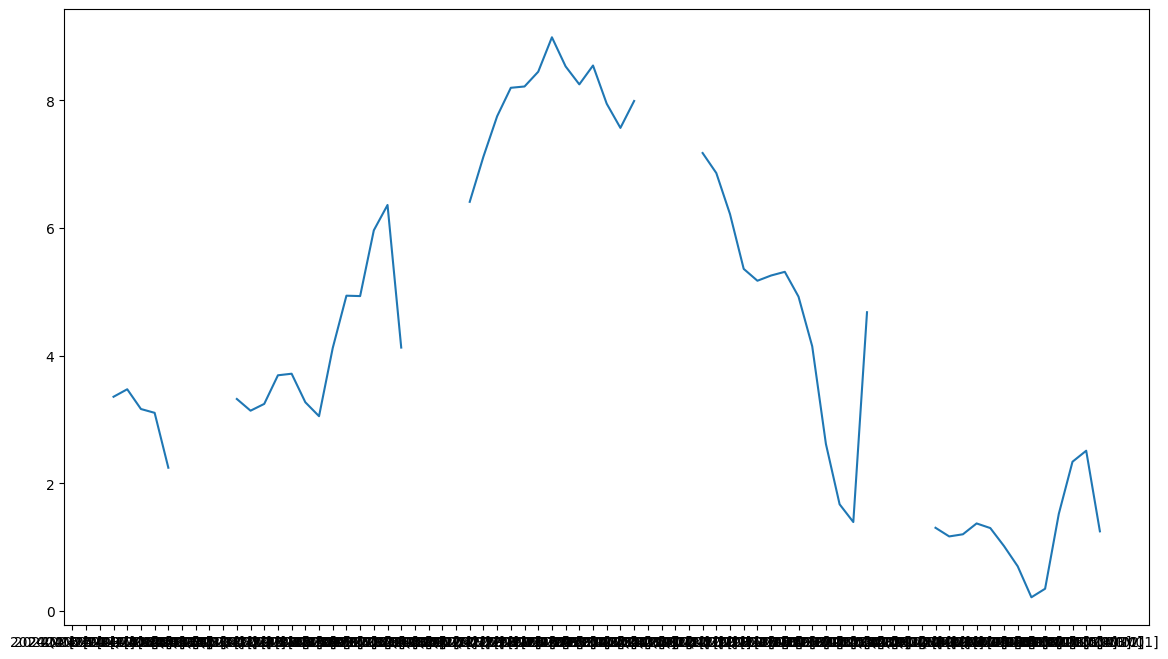

In [24]:

import matplotlib.pyplot as plt



# Extract columns for 2020 onwards (quarterly and monthly data)
columns_2020_onwards = [col for col in data.columns if ('2020' in col or '2021' in col or '2022' in col or '2023' in col or '2024' in col)]

# Add key identifying columns
columns_to_keep = ['Country', 'Country Code', 'Series', 'Series Code'] + columns_2020_onwards
filtered_data = data[columns_to_keep]

# Step 2: Select some example economic indicators
# We will use CPI and GDP growth rates as examples (we will pick relevant ones from the dataset)
key_indicators = ['CPI Price, % y-o-y, not seas. adj.,,', 'Real GDP, % y-o-y, seas. adj.,,']
filtered_indicators = filtered_data[filtered_data['Series'].isin(key_indicators)]

# Step 3: Clean the data - replace '..' with NaN and convert columns to numeric where possible
filtered_indicators.replace('..', pd.NA, inplace=True)
filtered_indicators[columns_2020_onwards] = filtered_indicators[columns_2020_onwards].apply(pd.to_numeric, errors='coerce')

# Step 4: Visualize Trends for Different Countries
# Let's visualize trends for two countries as an example: USA and Germany

countries_to_visualize = ['United States', 'Germany']
data_for_plotting = filtered_indicators[filtered_indicators['Country'].isin(countries_to_visualize)]

# Create plots for each country and indicator
plt.figure(figsize=(14, 8))

for idx, country in enumerate(countries_to_visualize):
    country_data = data_for_plotting[data_for_plotting['Country'] == country]
    
    for indicator in key_indicators:
        indicator_data = country_data[country_data['Series'] == indicator]
        plt.plot(columns_2020_onwards, indicator_data.iloc[0][columns_2020_onwards], label=f'{country} - {indicator}')

plt.title('Impact of COVID-19 on Economic Indicators (2020 Onwards)')
plt.xlabel('Time Period')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
# 
columns_quarterly_2020_onwards = ['2024Q2 [2024Q2]', '2024Q1 [2024Q1]',  '2023Q4 [2023Q4]', '2023Q3 [2023Q3]',
                                  '2023Q2 [2023Q2]', '2023Q1 [2023Q1]', '2022Q4 [2022Q4]', '2022Q3 [2022Q3]',
                                  '2022Q2 [2022Q2]', '2022Q1 [2022Q1]', '2021Q4 [2021Q4]', '2021Q3 [2021Q3]',
                                  '2021Q2 [2021Q2]', '2021Q1 [2021Q1]', '2020Q4 [2020Q4]', '2020Q3 [2020Q3]',
                                  '2020Q2 [2020Q2]', '2020Q1 [2020Q1]']

#
columns_to_keep = ['Country', 'Country Code', 'Series', 'Series Code'] + columns_quarterly_2020_onwards
filtered_data_quarterly = data[columns_to_keep]

# 
key_indicators = [ 'GDP,current US$,millions,seas. adj.,','CPI Price, seas. adj.,,,']
filtered_indicators_quarterly = filtered_data_quarterly[filtered_data_quarterly['Series'].isin(key_indicators)]

# 
filtered_indicators_quarterly.replace('..', pd.NA, inplace=True)
filtered_indicators_quarterly[columns_quarterly_2020_onwards] = filtered_indicators_quarterly[columns_quarterly_2020_onwards].apply(pd.to_numeric, errors='coerce')



countries_to_visualize = ['India']
data_for_plotting_quarterly = filtered_indicators_quarterly[filtered_indicators_quarterly['Country'].isin(countries_to_visualize)]

# 
plt.figure(figsize=(14, 8))

for idx, country in enumerate(countries_to_visualize):
    country_data = data_for_plotting_quarterly[data_for_plotting_quarterly['Country'] == country]
    
    for indicator in key_indicators:
        indicator_data = country_data[country_data['Series'] == indicator]
        if not indicator_data.empty:
            plt.plot(columns_quarterly_2020_onwards, indicator_data.iloc[0][columns_quarterly_2020_onwards], 
                     label=f'{country} - {indicator}')

plt.title('Impact of COVID-19 on Economic Indicators (2020 Q1 to 2024 Q2)')
plt.xlabel('Time Period')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
